In [1]:


import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller

path = os.getcwd()

prices = pd.read_csv(path + '/close.csv')
data = pd.DataFrame()
prices['Date'] = pd.to_datetime(prices['Date'])
prices.set_index('Date',inplace = True)
tickers = list(data.columns.values)
data = prices/prices.iloc[0]
trading_data = data.loc[data.index > '2017-09-08']
data = data.loc[data.index < '2017-09-09']
prices = prices.loc[prices.index > '2017-09-09']
trade_cost = 0.005


selected_pairs = [['HON','NEE'], ['TXN','SYK'],['BDX','SYK'], ['HON','DHR'],['JPM','PNC']]
half_life_sort = [['HON','NEE'], ['CMCSA','HON'],['MRK','SRE'], ['UPS','D'],['CCL','RHT']]
pearson_sort = [['MMM','MMC'], ['BDX','SYK'],['INTU','MMC'], ['MMC','APH'],['JPM','PNC']]

In [2]:
def trading_signals(first, second, trading_data = trading_data, formation_data = data):
    signal = 2*np.std(formation_data[first] - formation_data[second])
    result_dict = {}
    trading = False
    differences = trading_data[first] - trading_data[second]
    for i in range(len(differences)):
        if trading == False:
            if abs(differences.iloc[i]) > signal and abs(differences.iloc[i] < 2*signal):
                trading = True
                start_date = differences.index.values[i]
        else:
            if (differences.iloc[i-1] * differences.iloc[i] < 0) or (i == len(differences)-1) or abs(differences.iloc[i] > 2*signal):
                trading = False
                end_date = differences.index.values[i]
                if differences[i-1] > 0:
                    s_ret = (trading_data[first][start_date] - trading_data[first][end_date])/trading_data[first][start_date]
                    l_ret = (trading_data[second][end_date] - trading_data[second][start_date])/trading_data[second][start_date]
                    result_dict[start_date] = [first, second, start_date, end_date, s_ret,l_ret]
                else:
                    s_ret = (trading_data[second][start_date] - trading_data[second][end_date])/trading_data[second][start_date]
                    l_ret = (trading_data[first][end_date] - trading_data[first][start_date])/trading_data[first][start_date]
                    result_dict[start_date] = [second, first, start_date, end_date, s_ret,l_ret]
    df = pd.DataFrame.from_dict(result_dict, orient = 'index', columns = ['Short','Long','Start','End', 'SReturn','LReturn'])
    df.index = list(range(len(df)))
    df['Total'] = df['SReturn'] + df['LReturn']
    df['Length'] = (df['End'] - df['Start']).dt.days
    return (df, len(df))

In [3]:
def build_portfolio(trade_list, trading_data = trading_data):
    index_list = trading_data.index.tolist()
    portfolio = pd.DataFrame(index = trading_data.index.values, columns = ['Short','Long','ShortR','LongR','Trading'])
    l = trade_list[1]
    trade_list = trade_list[0]
    for i in range(len(trade_list)):
        start = trade_list['Start'][i]
        end = trade_list['End'][i]
        short = trade_list['Short'][i]
        lon = trade_list['Long'][i]
        di = index_list.index(start)
        di2 = index_list.index(end)
        for j in range(di2 - di + 1):
            date_index = di + j
            dt = index_list[date_index]
            portfolio['Short'][dt] = (trading_data[short][dt]/trading_data[short][index_list[di]]) + trade_cost
            portfolio['Long'][dt] = trading_data[lon][dt]/trading_data[lon][index_list[di]] - trade_cost
            portfolio['Trading'][dt] = 1
            if j == (di2 - di):
                portfolio['Short'][dt] = portfolio['Short'][dt] + trade_cost
                portfolio['Long'][dt] = portfolio['Long'][dt] - trade_cost

    portfolio.fillna(value = 0, axis = 0)
    for j in range(1, len(portfolio)):
        if portfolio.iloc[j-1]['Short'] > 0:
            portfolio.iloc[j]['ShortR'] = -(portfolio.iloc[j]['Short'] - portfolio.iloc[j-1]['Short'])/portfolio.iloc[j-1]['Long']
            portfolio.iloc[j]['LongR'] = (portfolio.iloc[j]['Long'] - portfolio.iloc[j-1]['Long'])/portfolio.iloc[j-1]['Long']
        else:
            portfolio.iloc[j]['ShortR'] = 0
            portfolio.iloc[j]['LongR']= 0
    portfolio['Total'] = portfolio['ShortR'] + portfolio['LongR']
    portfolio.fillna(0, inplace = True)
    return (portfolio, l)

In [4]:
def analyze_portfolio(pairs):
    i = 0
    df = (build_portfolio(trading_signals(pairs[i][0], pairs[i][1]))[0])
    trade_count = build_portfolio(trading_signals(pairs[i][0], pairs[i][1]))[1]
    for i in range(1, len(pairs)):
        df = df + (build_portfolio(trading_signals(pairs[i][0], pairs[i][1])))[0]
        trade_count += build_portfolio(trading_signals(pairs[i][0], pairs[i][1]))[1]
    df_short = df['ShortR']/5
    df_long = df['LongR']/5
    df_final = pd.concat([df_short, df_long], axis=1)
    df_final.columns = ['Short Return','Long Return']
    df_final.index.name = 'Date'
    df_final['Total'] = df_final['Short Return'] + df_final['Long Return']
    df_final.fillna(0, inplace = True)
    arithemtic_daily_mean = np.mean(df_final['Total'])
    annualized_return = (1+arithemtic_daily_mean)**250 - 1
    annualized_std = np.std(df_final['Total'])*np.sqrt(250)
    sharpe_ratio = annualized_return/annualized_std
    return [annualized_return, annualized_std, sharpe_ratio, trade_count]


In [9]:
optimal_selection = (analyze_portfolio(selected_pairs))
pvalue_selection = (analyze_portfolio(half_life_sort))
pearson_selection = (analyze_portfolio(pearson_sort))
print('Done')

Done


In [10]:
comparison_df = pd.DataFrame(data = np.array([optimal_selection, pvalue_selection, pearson_selection]))
comparison_df.index = np.array(['Industry Matched', 'Sorted by p-value','Sorted by Pearson Correlation'])
comparison_df.columns = ['Annualized Mean Return','Annualized SD of Daily Returns','Sharpe Ratio','Total Trades']
comparison_df['Annualized Mean Return'] = pd.Series(["{0:.2f}%".format(val * 100) for val in comparison_df['Annualized Mean Return']], index = comparison_df.index)
comparison_df['Annualized SD of Daily Returns'] = pd.Series(["{0:.2f}%".format(val * 100) for val in comparison_df['Annualized SD of Daily Returns']], index = comparison_df.index)
comparison_df['Total Trades'] = (comparison_df['Total Trades']*4)
comparison_df

,Annualized Mean Return,Annualized SD of Daily Returns,Sharpe Ratio,Total Trades
Industry Matched,8.27%,6.30%,1.312542,160.0
Sorted by p-value,-4.97%,17.45%,-0.284717,92.0
Sorted by Pearson Correlation,1.35%,6.97%,0.193498,76.0


In [11]:
def total_portfolio(pairs):
    i = 0
    df = (build_portfolio(trading_signals(pairs[i][0], pairs[i][1]))[0])
    trade_count = build_portfolio(trading_signals(pairs[i][0], pairs[i][1]))[1]
    for i in range(1, len(pairs)):
        df = df + (build_portfolio(trading_signals(pairs[i][0], pairs[i][1])))[0]
        trade_count += build_portfolio(trading_signals(pairs[i][0], pairs[i][1]))[1]
    df_short = df['ShortR']/5
    df_long = df['LongR']/5
    df_final = pd.concat([df_short, df_long], axis=1)
    df_final.columns = ['Short Return','Long Return']
    df_final.index.name = 'Date'
    df_final['Total'] = df_final['Short Return'] + df_final['Long Return']
    df_final.fillna(0, inplace = True)
    return df_final

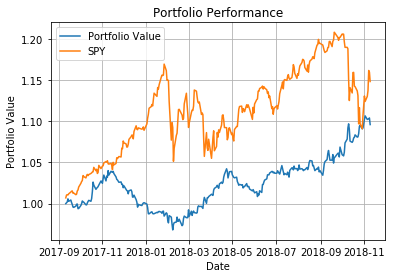

In [12]:
returns = (total_portfolio(selected_pairs))
#returns = (total_portfolio(half_life_sort))
#returns = (total_portfolio(pearson_sort))

portfolio = [1]
for i in range(1,len(returns)):
    portfolio.append(portfolio[i-1]*(1+returns.iloc[i]))

portfolio = [1]
short_portfolio = [1]
long_portfolio = [1]

for i in range(1,len(returns)):
    portfolio.append(portfolio[i-1]*(1+returns.iloc[i]['Total']))
    
for i in range(1,len(returns)):
    short_portfolio.append(portfolio[i-1]*(1+returns.iloc[i]['Short Return']))
    
for i in range(1,len(returns)):
    long_portfolio.append(portfolio[i-1]*(1+returns.iloc[i]['Long Return']))


SPY = pd.read_csv(path + '/SPY.csv')
SPY['Date'] = pd.to_datetime(SPY['Date'])
SPY.set_index('Date',inplace = True)
SPY = SPY/SPY.iloc[0]

    
result = pd.DataFrame(np.array([short_portfolio, long_portfolio, portfolio]).T, index = returns.index.values)
result.columns = ['Short','Long','Portfolio Value']
result = result.join(SPY)
result.columns = ['Short','Long','Portfolio Value', 'SPY']
plt.plot(result['Portfolio Value'])
plt.plot(result['SPY'])
plt.legend()
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Performance')
plt.grid()
plt.show
plt.savefig(path + '/compared_to_spy.png')
#plt.savefig(path + '/compared_to_spy_HL.png')
#plt.savefig(path + '/compared_to_spy_pearson.png')

In [104]:
def charts(first, second, data = data, trading_data = trading_data):
    hist_diff = data[first] - data[second]
    sd = np.std(hist_diff)
    title = first + '-' + second
    plt.plot(data[first])
    plt.plot(data[second])
    plt.title('%s Historical Prices' % title)
    plt.xlabel('Date')
    plt.ylabel('Normalized Prices')
    plt.legend()
    plt.grid()
    plt.savefig(path + '/pairs charts/%s Historical Prices' % title)
    plt.clf()

    plt.plot(hist_diff)
    plt.axhline(0, color = 'b', linewidth = 0.5)
    plt.axhline(2*sd, color = 'g', linewidth = 0.5)
    plt.axhline(-2*sd, color = 'g',linewidth = 0.5)
    plt.axhline(4*sd, color = 'r',linewidth = 0.5)
    plt.axhline(-4*sd, color = 'r',linewidth = 0.5)
    plt.title('%s Historical Differences' % title)
    plt.xlabel('Date')
    plt.ylabel('Difference')
    plt.grid()
    plt.savefig(path + '/pairs charts/%s Historical Differences' % title)
    plt.clf()

    plt.plot(trading_data[first])
    plt.plot(trading_data[second])
    plt.title('%s Past Year Prices' % title)
    plt.xlabel('Date')
    plt.ylabel('Normalized Prices')
    plt.legend()
    plt.grid()
    plt.savefig(path + '/pairs charts/%s Past Year Prices' % title)
    plt.clf() 

    plt.plot(trading_data[first] - trading_data[second])
    plt.axhline(0, color = 'b', linewidth = 0.5)
    plt.axhline(2*sd, color = 'g', linewidth = 0.5)
    plt.axhline(-2*sd, color = 'g',linewidth = 0.5)
    plt.axhline(4*sd, color = 'r',linewidth = 0.5)
    plt.axhline(-4*sd, color = 'r',linewidth = 0.5)
    plt.title('%s Historical Differences' % title)
    plt.xlabel('Date')
    plt.ylabel('Difference')
    plt.grid()
    plt.savefig(path + '/pairs charts/%s Past Year Differences' % title)
